# Import all required libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from f1predictions.orm.enums import DriverCategoryEnum
from f1predictions.load import load_models, create_materialized_views
from f1predictions.orm.config.database import get_session
from f1predictions.prediction.modelfactory import DriverRatingsModelFactory, DriverCategoryModelFactory
from f1predictions.orm.query import DriverRatingQuery, DriverQuery, DriverCategoryQuery
from f1predictions.prediction.regressors import LinearRegressorBuilder, DecisionTreeRegressorBuilder, \
    RandomForestRegressorBuilder

from f1predictions.prediction.classifiers import LogisticRegressionClassifierBuilder, DecisionTreeClassifierBuilder, \
    RandomForestClassifierBuilder, LightGBMClassifierBuilder, KNNClassifierBuilder

from f1predictions.utils import get_driver_ratings_predictor

from tabulate import tabulate

# Extract data
Extract data from .csv files and store them in a database. Also create materialized views that will help creating prediction models

In [2]:
load_models()
create_materialized_views()


Clearing database...
Loading drivers...
Loading circuits...
Loading statuses...
Loading constructors...
Loading races...
Loading rounds...
Loading drivers constructors...
Loading drivers results...
Loading constructors results...
Loading qualifying results...
Loading lap times...
Loading drivers standings...
Loading constructor standings...
Loading saved drivers ratings...
Loading saved drivers categories...
Creating drivers season results data materialized view
Creating drivers' opponents season results data materialized view
Creating drivers round results data materialized view
Creating drivers' opponents round results data materialized view


# Create driver ratings prediction models
Use views created above to create season rating prediction models.
The training model output will be taken from F1 [Power Rankings](https://www.formula1.com/en/latest/tags.power-rankings.699Peq5SC9zNGvwCkb1ln6.html)

## Model would look like this:

| wins | position | avg quali position | q2s | q3s | poles | front rows | podiums | dnfs | h2h quali | % constructor points |
|------|----------|--------------------|-----|-----|-------|------------|---------|------|-----------|----------------------|

### Description

- **q2**: Q2 appearance (top 15 in qualifying)
- **q3**: Q3 appearance (top 10 in qualifying)
- **poles**: pole positions
- **front rows**: pole positions or 2nd place in quali
- **dnfs**: 'did not finish'

## Model representation
Here is how the model looks like in form ready for processing

In [3]:
MAX_VERSTAPPEN_ID = 830
YEAR = 2023

driver_rating_query = DriverRatingQuery(get_session())
factory = DriverRatingsModelFactory(DriverQuery(get_session()))
model = factory.create_driver_ratings_model(MAX_VERSTAPPEN_ID, YEAR)
model.to_list()

[10, 1, 3.0, 12, 10, 8, 4, 12, 0, True, 62.66094420600859]

# Drivers rating prediction - regression algorithms
## Time for action!

Now we are going to train our models, and try to predict some drivers ratings that are not in the scope of our training set.

## Note: train/test model

In the code, you will see this line of code:
```create_train_test_set```
And then, while calculating score or so, you will see something like:
```print(linear_regression.get().score(linear_regression.X_test, linear_regression.y_test))```
It is a common approach, that allows us to evaluate our model against new data, while using only our example features.
It goes like this:

- Split your model into two separate parts - one named train model and second - test model (pick small value for test and larger for train model, for example 80/20 or 70/30 for smaller amount of data)
- Train your model using **train** data - the larger part
- Then, try to predict values from **test** model, and check their accuracy with actual values from that part of your model

This way, you can estimate how well your model adapts to new data. It also can give you guide about potential problems with your model - if it [**underfits** or **overfits**](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)

## Creating features and output values

In [4]:
driver_rating_query = DriverRatingQuery(get_session())
factory = DriverRatingsModelFactory(DriverQuery(get_session()))

ratings = driver_rating_query.get_drivers_ratings()

model = [factory.create_driver_ratings_model(i.driver_id, i.year) for i in ratings]

X = np.array([i.to_list() for i in model])
y = np.array([i.rating for i in ratings])

drivers_ids = [i.driver_id for i in ratings]

print('Number of training set: {}'.format(len(y)))
print('Number of features: {}'.format(len(X[0])))

Number of training set: 50
Number of features: 11


## Linear regression

We will start with simple linear regression. The 1/3 of our model would be used as a test, while the rest is a training set.

The builder classes helps us maintain creating regressor (and later also classifier) classes and keep code clean and tidy. These also store models that we can use for testing.

The `score()` method is a tool that helps us evaluate the accuracy of predictions

In [5]:
linear_regression_builder = LinearRegressorBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_regressor()

linear_reg = linear_regression_builder.get()

X_train, y_train, X_test, y_test = linear_regression_builder.X_train, linear_regression_builder.y_train, linear_regression_builder.X_test, linear_regression_builder.y_test

print('Score of linear regression: {}'.format(linear_reg.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(linear_reg.predict(X_test), y_test)))

Score of linear regression: 0.22495114023471607
Mean square error (MSE) of predictions: 0.22291370665636814


But what if we want to somehow plot our results? We need to somehow reduce the dimensions of our model...

## PCA (Principal Component Analysis)

PCA (Principal Component Analysis) is a dimensionality reduction technique that identifies key patterns in data by transforming it into a set of uncorrelated variables called principal components.

We will use this technique to reduce number of dimensions of our model to plot its values on a 2D canvas:

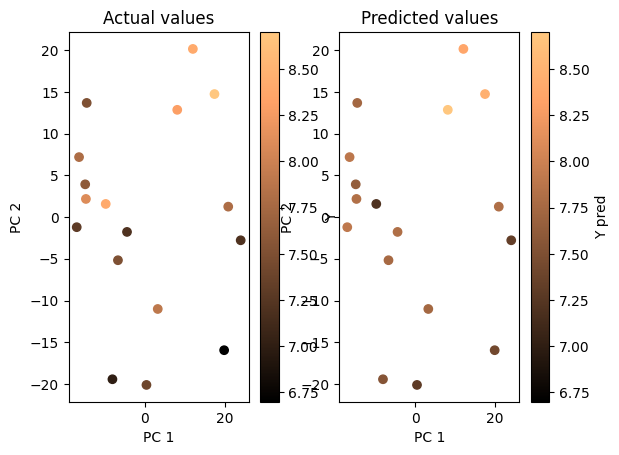

In [6]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

y_pred = linear_reg.predict(X_test)

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Actual values')

plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y pred')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Predicted values')

plt.show()

Here we can see the actual and predicted values scattered on two plots. Notice the colors of markers on a grid - different shades on dots in same place indicates that the predicted result is different than the actual value.

The linear regression method is not very effective - there are many differences between predicted and real values. We should try different approach.

# Decision tree

The next method is regression via the decision tree - sometimes very effective way of predicting values.

We are using builder for that matter, just like the previous time, with two differences:

- We have `set_criterion()` method, which chooses the function that will measure our split. We will use **absolute_error** for that matter, but feel free to test [other variants](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html),
- Our `create_regressor()` method expects parameter `max_depth`. We want to test how big level of depth would be optimal for our algorithm. Builder returns version with best score.

In [7]:
decision_tree_builder = DecisionTreeRegressorBuilder() \
    .set_model(X, y) \
    .set_criterion('absolute_error') \
    .create_train_test_set(0.33) \
    .create_regressor(25)

decision_tree = decision_tree_builder.get()

X_train, y_train, X_test, y_test = decision_tree_builder.X_train, decision_tree_builder.y_train, decision_tree_builder.X_test, decision_tree_builder.y_test

print('Score of decision tree: {}'.format(decision_tree.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(decision_tree.predict(X_test), y_test)))

Score of decision tree: 0.1895753128007691
Mean square error (MSE) of predictions: 0.23308823529411785


Not much improvement. Also, note that this method provides different results everytime you run code above - try a few times.

Let's see however, how this method looks like on a plot.

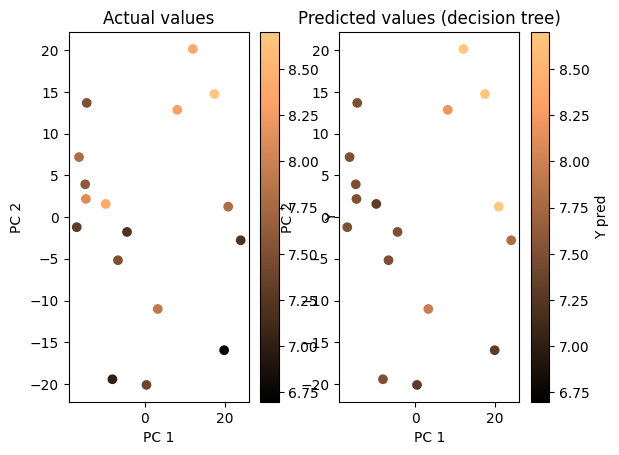

In [8]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

y_pred = decision_tree.predict(X_test)

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Actual values')

plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y pred')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Predicted values (decision tree)')

plt.show()

There is one improvement for this method, that significantly raise accuracy.

# Random forest

This is a combination of multiple decision trees, created using different random subsets of our training model data. 

The idea behind this technique is that each of this tree provides opinion about how to classify the data, and then the most popular result is being taken.

We can specify the number of decision trees our forest should consist of.

In [9]:
random_forest_builder = RandomForestRegressorBuilder() \
    .set_model(X, y) \
    .set_criterion('absolute_error') \
    .create_train_test_set(0.33) \
    .create_regressor(12)

random_forest = random_forest_builder.get()

X_train, y_train, X_test, y_test = random_forest_builder.X_train, random_forest_builder.y_train, random_forest_builder.X_test, random_forest_builder.y_test

print('Score of decision tree: {}'.format(random_forest.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(random_forest.predict(X_test), y_test)))

Score of decision tree: 0.4130786814244465
Mean square error (MSE) of predictions: 0.1688058823529412


That is a much better result! Almost doubled score of linear regression, and outscored single tree by more than that. And, more importantly, this method is stable - it provides the same results no matter how many times we run code.

Let's plot these predictions against the PCA-reduced model:

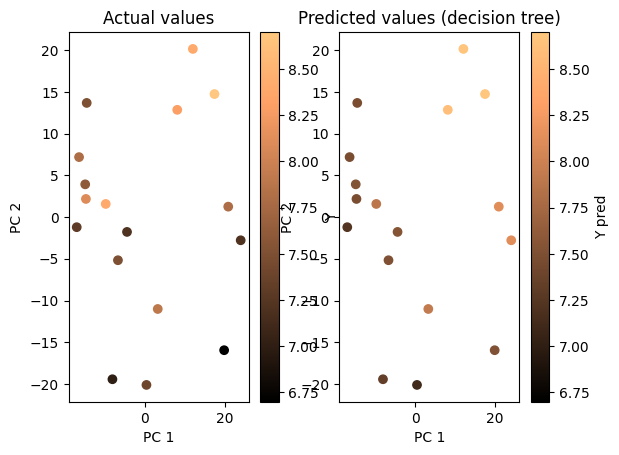

In [10]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

y_pred = random_forest.predict(X_test)

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Actual values')

plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='copper', vmin=min(y_test), vmax=max(y_test))
plt.colorbar(label='Y pred')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Predicted values (decision tree)')

plt.show()

# Driver rating predictions - summary

Now, let's see how our algorithms predicts values - and how the results looks like against the real ratings

In [11]:
driver_query = DriverQuery(get_session())
ratings, linalg_ratings, tree_ratings, forest_ratings = y, linear_reg.predict(X), decision_tree.predict(X), random_forest.predict(X)
drivers = []
for i in model:
    driver = driver_query.get_driver(i.driver_id)
    drivers.append(driver.name + ' ' + driver.surname)

data = [[drivers[i], ratings[i], round(linalg_ratings[i], 1), round(tree_ratings[i], 1), round(forest_ratings[i], 1)] for i in range(len(drivers))]
col_names = ['Driver', 'Actual rating', 'Linear regression rating', 'Decision tree rating', 'Random forest rating']
print(tabulate(data, headers=col_names, tablefmt='fancy_grid'))

╒══════════════════╤═════════════════╤════════════════════════════╤════════════════════════╤════════════════════════╕
│ Driver           │   Actual rating │   Linear regression rating │   Decision tree rating │   Random forest rating │
╞══════════════════╪═════════════════╪════════════════════════════╪════════════════════════╪════════════════════════╡
│ Max Verstappen   │             9.1 │                        9   │                    9.1 │                    8.5 │
├──────────────────┼─────────────────┼────────────────────────────┼────────────────────────┼────────────────────────┤
│ Lewis Hamilton   │             7.8 │                        7.9 │                    7.5 │                    7.6 │
├──────────────────┼─────────────────┼────────────────────────────┼────────────────────────┼────────────────────────┤
│ Lando Norris     │             7.6 │                        7.6 │                    7.5 │                    7.5 │
├──────────────────┼─────────────────┼──────────────────

(**Note**: the repeated drivers names are here because of different years that the ratings had been taken from)

# Main course - assign driver a category - classicifation problem

This is what we were trying to do from the beginning, while the ratings were just a _side dish_ - an additional, partially synthesized, feature.

## The problem itself
We have four categories:

- **Championship material (0)** - a driver who is destinated to win at least one world champion title. Absolute top of the top,
- **Race winner (1)** - athlete capable of winning a race now and then, but not _complete_ enough to be able to win a season trophy,
- **Points scorer (2)** - the one who can score points on a regular basis, and potentially claim a podium or two, but nothing more,
- **Backmarker (3)** - driver who is not capable of getting into first 10 from race to race, and therefore, scoring regular points

## The model
The model is mostly the same, with one added feature - rating - which we need to predict using beforementioned methods. We will be relying on **predicted** model only, using the random forest method, as its accuracy was highest:
| wins | position | avg quali position | q2s | q3s | poles | front rows | podiums | dnfs | h2h quali | % constructor points | rating |
|------|----------|--------------------|-----|-----|-------|------------|---------|------|-----------|----------------------|--------|

## The data
We have 72 records of drivers, mostly from years 2019-2023, who have been given a category based on their seasons results. This would be our training data for that matter.

In [14]:
driver_categories_query = DriverCategoryQuery(get_session())
driver_ratings_factory = DriverRatingsModelFactory(DriverQuery(get_session()))
factory = DriverCategoryModelFactory(driver_ratings_factory)
ratings_predictor = get_driver_ratings_predictor(DriverRatingQuery(get_session()), driver_ratings_factory).get()

categories = driver_categories_query.get_drivers_categories()

drivers = []
for i in categories:
    driver = driver_query.get_driver(i.driver_id)
    drivers.append(driver.name + ' ' + driver.surname)

drivers
data = [[drivers[i], categories[i].year, categories[i].category.name] for i in range(len(categories))]
col_names = ['Driver', 'Year (season)', 'Category']
print(tabulate(data[: 10], headers=col_names, tablefmt='fancy_grid'))

╒══════════════════╤═════════════════╤══════════════════════╕
│ Driver           │   Year (season) │ Category             │
╞══════════════════╪═════════════════╪══════════════════════╡
│ Lewis Hamilton   │            2023 │ RaceWinner           │
├──────────────────┼─────────────────┼──────────────────────┤
│ Fernando Alonso  │            2023 │ RaceWinner           │
├──────────────────┼─────────────────┼──────────────────────┤
│ Nico Hülkenberg  │            2023 │ PointsScorer         │
├──────────────────┼─────────────────┼──────────────────────┤
│ Sergio Pérez     │            2023 │ RaceWinner           │
├──────────────────┼─────────────────┼──────────────────────┤
│ Daniel Ricciardo │            2023 │ PointsScorer         │
├──────────────────┼─────────────────┼──────────────────────┤
│ Valtteri Bottas  │            2023 │ PointsScorer         │
├──────────────────┼─────────────────┼──────────────────────┤
│ Kevin Magnussen  │            2023 │ Backmarker           │
├───────

Above we can see a short excerpt of our result values - later we would try to predict all values and check them against the actual categories, just as before with regression part.

# Classification algorithms

Just as before, we have few approaches towards the classification problem:

- Logistic regression
- Decision tree classification
- Random forest classification
- LightGBM classification
- K-Nearest Neighbours classification

We will try to evaluate each one of these in next chapters, but, first of all, we need to build our model:

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = [
        factory.create_driver_category_model(
            i.driver_id,
            i.year,
            float(ratings_predictor.predict(np.array(driver_ratings_factory.create_driver_ratings_model(i.driver_id, i.year).to_list()).reshape(1, -1))))
        for i in categories
    ]

X = np.array([i.to_list() for i in model])
y = np.array([i.category.value for i in categories])

print('Size of training set: {}'.format(len(y)))
print('Number of features: {}'.format(len(X[0])))

Size of training set: 72
Number of features: 12


## Logistic regression

Simplest, yet sometimes very effective algorithm that can produce results quickly.

Just as before, we would use a train/test model that we can create using builders provided in codebase.

In [18]:
classifier_builder = LogisticRegressionClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier('ovr', 'liblinear')

classifier = classifier_builder.get()

X_train, y_train, X_test, y_test = classifier_builder.X_train, classifier_builder.y_train, classifier_builder.X_test, classifier_builder.y_test

print('Score of logistic regression classifier: {}'.format(classifier.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(classifier.predict(X_test), y_test)))

Score of logistic regression classifier: 0.5416666666666666
Mean square error (MSE) of predictions: 0.7916666666666666


(**Note**: the `ovr` while creating classifier means that is a _one-versus-rest_ classification, which is a common approach for multiclass regression)

The score looks pretty good, but the MSE is high, too. What does it mean?

Well, let's talk about confusion matrices

## Confusion matrix

The idea of confusion matrix (also known as error matrix) is to show us the predicted and actual data in form of four values:

- **True positives** - the values that are positive in both predicted and actual cases,
- **True negatives** - the values that are _negatives_ (not true) for both cases,
- **False positives (type 1 error)** - these are the values that has been predicted as **true**, while they should be set to **false**,
- **False negatives (type 2 error)** - in opposition to Type 1 error, these are wrongly predicted **false** values

We have a multiclass classification problem, so everything in our matrix should be multiplier times four.

This is how our matrix looks like for logistic regression classifier:

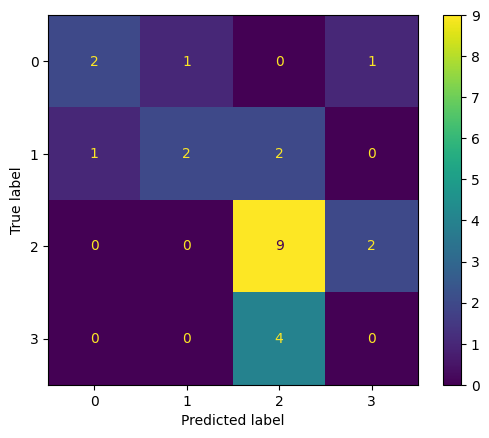

In [21]:
y_pred = classifier.predict(classifier_builder.X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In case of such classification, the __correct__ values lies on a diagonal line from point (0,0) down bottom to (3,3) - these are values that has been correctly predicted. All the other values have been misclassified.

That is indeed not too bad - however, the alarming part is the absence of backmarker category predictions.

## Decision tree classifier

Let's see different method - a decision tree classifier.

Score of logistic regression classifier: 0.7916666666666666
Mean square error (MSE) of predictions: 0.5416666666666666


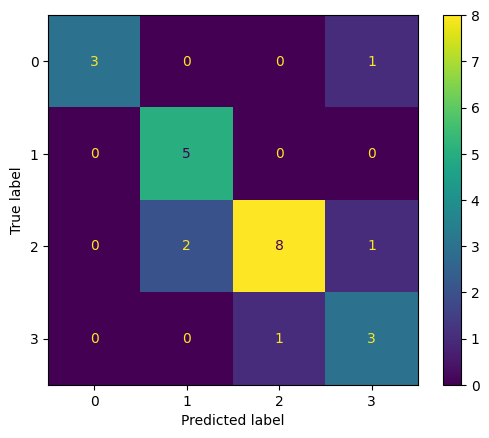

In [22]:
decision_tree_builder = DecisionTreeClassifierBuilder() \
    .set_model(X, y) \
    .set_criterion('log_loss') \
    .create_train_test_set(0.33) \
    .create_classifier(12)

decision_tree = decision_tree_builder.get()

X_train, y_train, X_test, y_test = decision_tree_builder.X_train, decision_tree_builder.y_train, decision_tree_builder.X_test, decision_tree_builder.y_test

y_pred = decision_tree.predict(decision_tree_builder.X_test)

print('Score of logistic regression classifier: {}'.format(decision_tree.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(y_test, y_pred)))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

This generally works much better, with one problem - a single tree still can product different results each time we run this code. Try it a few times - sometimes the score is around 0.7 and MSE is lower that 0.5, but there are runs where results can be much worse.

Let's try to resolve this issue

## Random Forest

Random forest of decision trees was providing the best result for our regression problem. Let's see, how well it will perform for classification.

Score of logistic regression classifier: 0.7083333333333334
Mean square error (MSE) of predictions: 0.4166666666666667


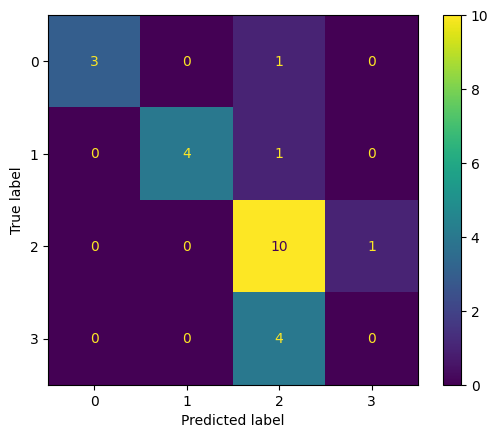

In [23]:
random_forest_builder = RandomForestClassifierBuilder() \
    .set_model(X, y) \
    .set_criterion('log_loss') \
    .create_train_test_set(0.33) \
    .create_classifier(15)

random_forest = random_forest_builder.get()

X_train, y_train, X_test, y_test = random_forest_builder.X_train, random_forest_builder.y_train, random_forest_builder.X_test, random_forest_builder.y_test

y_pred = random_forest.predict(random_forest_builder.X_test)

print('Score of logistic regression classifier: {}'.format(random_forest.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(y_test, y_pred)))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

The score and MSE values are pretty good, and the algorithm is stable, however...

There is a problem with missclassification again - at least at the time I was testing this method - where none of the backmarkers was classified correctly. This is not acceptable, as we want to have correct predictions across all categories.

However, we have two more methods to look at.

## LightGBM

LightGBM is a quick and efficient way to make predictions in machine learning. It builds decision trees in a way of focusing on fixing the biggest mistakes first. This makes it fast, especially with lots of data. It also handles different kinds of information well and doesn't get too complicated.

Let's see it in action.

Score of logistic regression classifier: 0.625
Mean square error (MSE) of predictions: 0.5


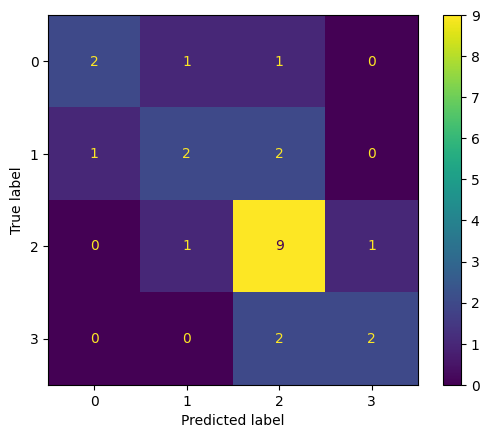

In [24]:
lightgbm_builder = LightGBMClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier(8)

lightgbm_classifier = lightgbm_builder.get()

y_pred = lightgbm_classifier.predict(lightgbm_builder.X_test)

X_train, y_train, X_test, y_test = lightgbm_builder.X_train, lightgbm_builder.y_train, lightgbm_builder.X_test, lightgbm_builder.y_test

print('Score of logistic regression classifier: {}'.format(lightgbm_classifier.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(y_test, y_pred)))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

While being less accurate than random forest, it provides pretty even correct-to-misclassified predictions, and is as stable as aforementioned.

This looks like a leader for now, but let's check the last one

## k-Nearest Neighbours

KNN, or k-Nearest Neighbors, is a simple algorithm for classification and regression. In simple terms, it works like this: to predict a new data point, KNN looks at the 'k' nearest points in the training data and takes a majority vote (for classification) or averages (for regression) to make its prediction. It's like asking your closest neighbors for advice.

Score of logistic regression classifier: 0.5833333333333334
Mean square error (MSE) of predictions: 0.5416666666666666


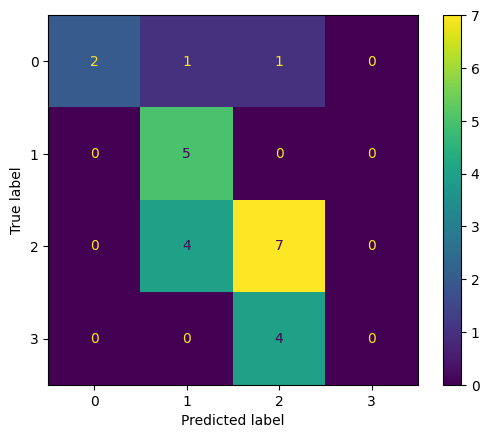

In [25]:
knn_builder = KNNClassifierBuilder() \
    .set_model(X, y) \
    .create_train_test_set(0.33) \
    .create_classifier(15)

knn_classifier = knn_builder.get()

y_pred = knn_classifier.predict(knn_builder.X_test)

X_train, y_train, X_test, y_test = knn_builder.X_train, knn_builder.y_train, knn_builder.X_test, knn_builder.y_test

print('Score of logistic regression classifier: {}'.format(knn_classifier.score(X_test, y_test)))
print('Mean square error (MSE) of predictions: {}'.format(mean_squared_error(y_test, y_pred)))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

It cannot beat the leader - the disproportion between right and wrong values is bigger, and the accuracy is smaller.

Therefore, the best classification algorithm for this task is LightGBM, which is not ideal, and does not even provide best accuracy (single decision tree and random forest beat it), but does it in stable way and with more even distribution between false and true predictions.

Let's, however' see the summary

# Drivers categories - summary

Just like before - let's see side-by-side comparison between each of the algorithms - across whole 72 model records.

In [27]:
driver_query = DriverQuery(get_session())
categories, logreg_categories, tree_categories, forest_categories, lightgbm_categories, knn_categories = y, classifier.predict(X), decision_tree.predict(X), random_forest.predict(X), lightgbm_classifier.predict(X), knn_classifier.predict(X)
drivers = []
for i in model:
    driver = driver_query.get_driver(i.driver_rating_model.driver_id)
    drivers.append(driver.name + ' ' + driver.surname)

data = [[drivers[i], DriverCategoryEnum(categories[i]).name, DriverCategoryEnum(logreg_categories[i]).name, DriverCategoryEnum(tree_categories[i]).name, DriverCategoryEnum(forest_categories[i]).name, DriverCategoryEnum(lightgbm_categories[i]).name, DriverCategoryEnum(knn_categories[i]).name] for i in range(len(drivers))]
col_names = ['Driver', 'Actual categories', 'Logistic regression categories', 'Decision tree categories', 'Random forest categories', 'LightGBM categories', 'KNN categories']
print(tabulate(data, headers=col_names, tablefmt='fancy_grid'))

╒════════════════════╤══════════════════════╤══════════════════════════════════╤════════════════════════════╤════════════════════════════╤═══════════════════════╤══════════════════════╕
│ Driver             │ Actual categories    │ Logistic regression categories   │ Decision tree categories   │ Random forest categories   │ LightGBM categories   │ KNN categories       │
╞════════════════════╪══════════════════════╪══════════════════════════════════╪════════════════════════════╪════════════════════════════╪═══════════════════════╪══════════════════════╡
│ Lewis Hamilton     │ RaceWinner           │ RaceWinner                       │ RaceWinner                 │ RaceWinner                 │ RaceWinner            │ RaceWinner           │
├────────────────────┼──────────────────────┼──────────────────────────────────┼────────────────────────────┼────────────────────────────┼───────────────────────┼──────────────────────┤
│ Fernando Alonso    │ RaceWinner           │ RaceWinner              